<table style="border: none" align="left">
<tr style="border: none">
<th style="border: none"><img src="http://i.imgur.com/o1X3CAd.jpg" alt="Icon" align="left"></th>
</tr>
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="6" color="black"><b>Cognihack Data Science Track</b></font></th>
   </tr>
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="5" color="black"><b>Predicting repeat shopping likelihood with Python, Spark and Watson Machine Learning</b></font></th>
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/3897/media/shoppers_lores.png" alt="Icon" align="left"> </th>
   </tr>
</table>

This notebook will take you through the process of creating a predictive model in Python using the data manipulation and machine learning libraries distributed with Spark.  
- The data we are using here is an open source dataset prepared for a [machine learning challenge](https://www.kaggle.com/c/acquire-valued-shoppers-challenge) hosted on the [Kaggle](https://www.kaggle.com/) website.  

Once we've worked through the process of reading, understanding and preparing our data and have built a simple model together, we'll deploy it to the [Watson Machine Learning service](https://datascience.ibm.com/features#machinelearning) and make it available as a real-time scoring service.  

You should spend the remaining time working as a group to speculate on how you might improve these predictions. The cognihack tutors will endeavour to assist with any experimentation to help you create and evaluate refinements to the baseline model.

# Learning goals

The learning goals of this exercise are:

-  Loading CSV files into an Apache® Spark DataFrame.
-  Exploring the data using the features within:  
    a) Spark's data wrangling Python API: __pyspark.sql__;  
    b) the __pandas__ data wrangling library; and  
    c) __matplotlib__ for exploratory plots.  
-  Engineering some basic predictive features, again using __pyspark.sql__ and Spark __user defined functions (UDFs)__.
-  Preparing the data for training and evaluation.
-  Creating an Apache® Spark machine learning pipeline.
-  Training and evaluating a model.
-  Persisting a pipeline and model in Watson Machine Learning repository.
-  Deploying the model for online scoring using Wastson Machine Learning API.
-  Scoring sample scoring data using the Watson Machine Learning API.


# Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Load and understand data](#load)
3.  [Prepare dataset](#prepare)
4.	[Create a basic model](#model)
5.	[Deploy and score](#deploy)
6.	[Taking it further](#tuning)

<a id="setup"></a>
# 1. Setup
Before we begin working through this notebook, you must perform the following setup tasks:

-  Sign up for the IBM Data Science Experience (using w3 credentials) and create a new project;
-  Retrieve the **Acquire Valued Shoppers Challenge** data from the [Cognihack Box folder](https://ibm.ent.box.com/folder/25592156534);
-  Import the data (in csv format) into the Data Science Experience as a 'data asset' (the transactions_subset.csv file will require decompression prior to upload);
-  Make sure that you are using a Spark 2.0 kernel and Python 2.x; and
-  Create a [Watson Machine Learning Service](https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/) instance (a free plan is offered).

<a id="load"></a>
# 2. Load and explore data

## 2.1 Load the data
The first step in our analysis process is to bring our data into the Spark environment.  To do this, you will need to experiment with the 'Find and Add Data' functionality within the notebooks environment (see sidebar):
1.  Find the entry corresponding to one of the .CSV files you uploaded as a data asset.
2.  Click into the blank cell below this one so that you can see the cursor is ready to insert text.
3.  Select 'insert credentials' from the drop-down menu next to the file name.

If everthing has worked correctly, you should now see some code in the cell below defining a new __Python dict__ named *credentials_1*.

In [96]:
# The code was removed by DSX for sharing.

__pyspark.sql__ will help us load and manipulate our data from Python while it resides in Spark.

In [97]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

This function is used to setup the access of Spark to your Object Storage.

In [99]:
def set_hadoop_config_with_credentials(name):
    """This function sets the Hadoop configuration so it is possible to
    access data from Bluemix Object Storage using Spark"""

    prefix = 'fs.swift.service.' + name
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + '.auth.url', credentials_1["auth_url"] +'/v3/auth/tokens')
    hconf.set(prefix + '.auth.endpoint.prefix', 'endpoints')
    hconf.set(prefix + '.tenant', credentials_1["project_id"])
    hconf.set(prefix + '.username', credentials_1["user_id"])
    hconf.set(prefix + '.password', credentials_1["password"])
    hconf.setInt(prefix + '.http.port', 8080)
    hconf.set(prefix + '.region', credentials_1["region"])
    hconf.setBoolean(prefix + '.public', False)

# you can choose any name
name = 'keystone'
set_hadoop_config_with_credentials(name)

spark = SparkSession.builder.getOrCreate()


The _spark.read_ function will import a flat file into our spark instance, directly from the Object Store.

In [102]:
offers = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load('swift://' + credentials_1["container"] + '.' + name + '/offers.csv')

trainHistory = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load('swift://' + credentials_1["container"] + '.' + name + '/trainHistory.csv')
    
transactions = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load('swift://' + credentials_1["container"] + '.' + name + '/transactions_subset.csv')

When this is done, we are left with is a Python object which is a logical pointer to a Spark DataFrame object.  
Notice as well that Spark will give us some information on how it is breaking down the heavy lifting into discrete and parallelisable tasks.

## 2.2 Quality and completeness
Before we can get stuck into building predictive models, we need to first understand if any immediate attention is required to issues of data quality and completeness.

Like many data manipulation libraries, Spark makes its own decisions about how to read in data.  
To check it has treated our data as we expected, we need to compare the schemata of our Spark DataFrames to that provided with the datasets:

> 
__history__  
__id__ - A unique id representing a customer  
__chain__ - An integer representing a store chain  
__offer__ - An id representing a certain offer  
__market__ - An id representing a geographical region  
__repeattrips__ - The number of times the customer made a repeat purchase  
__repeater__ - A boolean, equal to repeattrips > 0  
__offerdate__ - The date a customer received the offer  
>
__transactions__  
__id__ - see above  
__chain__ - see above  
__dept__ - An aggregate grouping of the Category (e.g. water)  
__category__ - The product category (e.g. sparkling water)  
__company__ - An id of the company that sells the item  
__brand__ - An id of the brand to which the item belongs  
__date__ - The date of purchase  
__productsize__ - The amount of the product purchase (e.g. 16 oz of water)  
__productmeasure__ - The units of the product purchase (e.g. ounces)  
__purchasequantity__ - The number of units purchased  
__purchaseamount__ - The dollar amount of the purchase  
>
__offers__  
__offer__ - see above  
__category__ - see above  
__quantity__ - The number of units one must purchase to get the discount  
__company__ - see above  
__offervalue__ - The dollar value of the offer  
__brand__ - see above  
>
The transactions file can be joined to the history file by (id,chain). The history file can be joined to the offers file by (offer). The transactions file can be joined to the offers file by (category, brand, company). A negative value in productquantity and purchaseamount indicates a return.

While we're at it, let's also see how many observations each dataset has, take a peek at the data and look for any missing values.

### 2.2.1 Offer details

First up, the count of observations in the dataset.

In [103]:
offers.count()

37

A small, reference dataset.

Next question: how is the data typed within the Spark DataFrame?

In [104]:
offers.schema

StructType(List(StructField(offer,StringType,true),StructField(category,StringType,true),StructField(quantity,StringType,true),StructField(company,StringType,true),StructField(offervalue,StringType,true),StructField(brand,StringType,true)))

Spark has interpreted every field as a string. 🙄

There are two fields: _offervalue_ and _quantity_ that definitely should not be strings - let's fix them up now.

In [105]:
offers = offers.withColumn("offervalue", offers["offervalue"].cast("double"))
offers = offers.withColumn("quantity", offers["quantity"].cast("double"))

Now we're ready to take a peak at the data.

In [106]:
offers.show()

+-------+--------+--------+----------+----------+------+
|  offer|category|quantity|   company|offervalue| brand|
+-------+--------+--------+----------+----------+------+
|1190530|    9115|     1.0| 108500080|       5.0| 93904|
|1194044|    9909|     1.0| 107127979|       1.0|  6732|
|1197502|    3203|     1.0| 106414464|      0.75| 13474|
|1198271|    5558|     1.0| 107120272|       1.5|  5072|
|1198272|    5558|     1.0| 107120272|       1.5|  5072|
|1198273|    5558|     1.0| 107120272|       1.5|  5072|
|1198274|    5558|     1.0| 107120272|       1.5|  5072|
|1198275|    5558|     1.0| 107120272|       1.5|  5072|
|1199256|    4401|     1.0| 105100050|       2.0| 13791|
|1199258|    4401|     1.0| 105100050|       2.0| 13791|
|1200578|    1703|     1.0| 104460040|       1.5|  7668|
|1200579|    1703|     1.0| 104460040|       1.5|  7668|
|1200581|    1726|     1.0| 104460040|      1.25|  7668|
|1200582|    1726|     1.0| 104460040|      1.25|  7668|
|1200584|    3504|     1.0| 104

And finally, check for any records with a missing value in critical fields.

In [107]:
offers.where(offers.offer.isNull() |
            offers.category.isNull() |
            offers.quantity.isNull() |
            offers.company.isNull() |
            offers.offervalue.isNull() |
            offers.brand.isNull()).count()

0

### 2.2.2 Customer-Offer History

Can you repeat the same operations here?
1.  Count the records;
2.  Inspect the type schema;
3.  Convert miss-typed fields using _withColumn()_ and _cast()_;
4.  Inspect the data; and
5.  Check the dataset for missing values.

In [108]:
trainHistory.count()

160057

A larger dataset that relates offers and customers.

In [109]:
trainHistory.schema

StructType(List(StructField(id,StringType,true),StructField(chain,StringType,true),StructField(offer,StringType,true),StructField(market,StringType,true),StructField(repeattrips,StringType,true),StructField(repeater,StringType,true),StructField(offerdate,StringType,true)))

Same deal. Let's do some conversion to numeric and datetime types.

In [110]:
trainHistory = trainHistory.withColumn("repeattrips", trainHistory["repeattrips"].cast("double"))
trainHistory = trainHistory.withColumn("repeater", trainHistory["repeater"].cast("boolean"))
trainHistory = trainHistory.withColumn("repeater", trainHistory["repeater"].cast("double"))
trainHistory = trainHistory.withColumn("offerdate", trainHistory["offerdate"].cast("date"))

In [111]:
trainHistory.show()

+--------+-----+-------+------+-----------+--------+----------+
|      id|chain|  offer|market|repeattrips|repeater| offerdate|
+--------+-----+-------+------+-----------+--------+----------+
|   86246|  205|1208251|    34|        5.0|     1.0|2013-04-24|
|   86252|  205|1197502|    34|       16.0|     1.0|2013-03-27|
|12682470|   18|1197502|    11|        0.0|     0.0|2013-03-28|
|12996040|   15|1197502|     9|        0.0|     0.0|2013-03-25|
|13089312|   15|1204821|     9|        0.0|     0.0|2013-04-01|
|13179265|   14|1197502|     8|        0.0|     0.0|2013-03-29|
|13251776|   15|1200581|     9|        0.0|     0.0|2013-03-30|
|13540129|   14|1200581|     8|        0.0|     0.0|2013-03-30|
|13807224|    4|1204576|     1|        0.0|     0.0|2013-04-05|
|13873775|    4|1197502|     1|        0.0|     0.0|2013-03-26|
|13974451|    4|1197502|     1|        0.0|     0.0|2013-03-26|
|14088807|    3|1200581|     2|        1.0|     1.0|2013-04-17|
|14381137|    4|1197502|     1|        0

In [112]:
trainHistory.where(trainHistory.chain.isNull() | 
                  trainHistory.market.isNull() |
                  trainHistory.repeattrips.isNull() |
                  trainHistory.repeater.isNull() |
                  trainHistory.offerdate.isNull()).count()

0

### 2.2.3 Transactions

In [113]:
transactions.count()

27764694

The largest of the three datasets.

In [114]:
transactions.schema

StructType(List(StructField(id,StringType,true),StructField(chain,StringType,true),StructField(dept,StringType,true),StructField(category,StringType,true),StructField(company,StringType,true),StructField(brand,StringType,true),StructField(date,StringType,true),StructField(productsize,StringType,true),StructField(productmeasure,StringType,true),StructField(purchasequantity,StringType,true),StructField(purchaseamount,StringType,true)))

In [115]:
transactions = transactions.withColumn("date", transactions["date"].cast("date"))
transactions = transactions.withColumn("productsize", transactions["productsize"].cast("double"))
transactions = transactions.withColumn("purchasequantity", transactions["purchasequantity"].cast("double"))
transactions = transactions.withColumn("purchaseamount", transactions["purchaseamount"].cast("double"))

In [116]:
transactions.show()

+-----+-----+----+--------+----------+-----+----------+-----------+--------------+----------------+--------------+
|   id|chain|dept|category|   company|brand|      date|productsize|productmeasure|purchasequantity|purchaseamount|
+-----+-----+----+--------+----------+-----+----------+-----------+--------------+----------------+--------------+
|86246|  205|   3|     305| 103320030|  875|2013-03-09|       16.0|            OZ|             1.0|          0.99|
|86246|  205|   3|     305| 103320030|  875|2013-03-10|       32.0|            OZ|             1.0|          1.69|
|86246|  205|   3|     305| 103320030|  875|2013-04-04|        8.0|            OZ|             2.0|          1.38|
|86246|  205|   6|     610| 108079383|12778|2013-04-20|       16.0|            OZ|             1.0|          1.99|
|86246|  205|   7|     703|1076211171|17286|2012-06-16|       0.93|            OZ|             1.0|          7.09|
|86246|  205|   7|     706| 101200010|17286|2013-03-03|        9.5|            O

In [117]:
transactions.where(transactions.id.isNull() |
                  transactions.chain.isNull() |
                  transactions.dept.isNull() |
                  transactions.category.isNull() |
                  transactions.company.isNull() |
                  transactions.brand.isNull() |
                  transactions.date.isNull() |
                  transactions.productsize.isNull() |
                  transactions.productmeasure.isNull() |
                  transactions.purchasequantity.isNull() |
                  transactions.purchaseamount.isNull()).count()

0

## 2.3 Exploration
Let's begin interpreting the contents of these sets, starting with the range of dates over which the offers were presented to customers.

In [118]:
trainHistory.agg(
    F.min("offerdate").alias("offerdate_min")
    , F.max("offerdate").alias("offerdate_max")).show()

+-------------+-------------+
|offerdate_min|offerdate_max|
+-------------+-------------+
|   2013-03-01|   2013-04-30|
+-------------+-------------+



What is the frequency of records across some of the categorical variables?

In [119]:
trainHistory.groupBy(trainHistory.chain).count().orderBy("count", ascending = False).show(n = 50)

+-----+-----+
|chain|count|
+-----+-----+
|   21|27373|
|  152|10967|
|   96| 8657|
|   64| 5889|
|  360| 5880|
|   46| 5440|
|  153| 4850|
|  101| 4727|
|  166| 3499|
|  214| 3390|
|  377| 2977|
|    6| 2808|
|   42| 2711|
|   89| 2604|
|  285| 2589|
|  507| 2586|
|  165| 2484|
|  240| 2465|
|  508| 2375|
|   15| 2305|
|   98| 2042|
|   70| 1967|
|   24| 1922|
|   77| 1820|
|    4| 1753|
|  126| 1717|
|   26| 1677|
|   83| 1675|
|    2| 1652|
|  143| 1484|
|  510| 1454|
|  104| 1429|
|   12| 1406|
|  191| 1391|
|  211| 1380|
|   31| 1380|
|    8| 1327|
|  206| 1249|
|   16| 1224|
|   58| 1162|
|   18| 1144|
|   63| 1136|
|  431| 1121|
|   85| 1057|
|   65| 1036|
|  100|  988|
|   68|  955|
|   17|  935|
|  151|  929|
|   14|  755|
+-----+-----+
only showing top 50 rows



Probably too many of these to do anything useful without grouping.

Try for yourself with the _market_ variable.

In [120]:
trainHistory.groupBy(trainHistory.market).count().orderBy("count", ascending = False).show(n = 50)

+------+-----+
|market|count|
+------+-----+
|    10|41724|
|    21| 9919|
|    27| 8657|
|    37| 7700|
|     9| 7648|
|    20| 7438|
|    15| 7434|
|    12| 7345|
|    96| 6895|
|     8| 6187|
|    14| 5310|
|     1| 5037|
|     4| 4804|
|    16| 4631|
|    34| 4045|
|    33| 3525|
|    35| 2652|
|     2| 2044|
|     7| 2003|
|    39| 1982|
|    18| 1903|
|    11| 1715|
|    28| 1538|
|    22| 1495|
|    17| 1384|
|    24| 1380|
|    26| 1036|
|    43|  668|
|    45|  631|
|    23|  511|
|     6|  491|
|    93|  188|
|    47|   71|
|     5|   66|
+------+-----+



Slightly more usable, perhaps we'll come back to this.

In [121]:
trainHistory.describe(["repeattrips", "repeater"]).show()

+-------+-----------------+-------------------+
|summary|      repeattrips|           repeater|
+-------+-----------------+-------------------+
|  count|           160057|             160057|
|   mean|0.656334930680945|0.27139081702143614|
| stddev|6.786515664667542|0.44467862202604597|
|    min|              0.0|                0.0|
|    max|           2124.0|                1.0|
+-------+-----------------+-------------------+



First insight: 27% of customers to whom an offer is made become repeat shoppers. Does this vary across _market_?

In [122]:
trainHistory.groupBy(trainHistory.market).agg(
    F.count("id").alias("customer_count")
    , F.avg("repeater").alias("response_rate")
    ).orderBy("response_rate", ascending = False).show()

+------+--------------+-------------------+
|market|customer_count|      response_rate|
+------+--------------+-------------------+
|    14|          5310|0.44689265536723166|
|    21|          9919| 0.3638471620122996|
|    34|          4045|0.31470951792336216|
|     9|          7648| 0.2906642259414226|
|    35|          2652| 0.2888386123680241|
|    10|         41724| 0.2863819384526891|
|    27|          8657|0.28323899734319047|
|     4|          4804| 0.2810158201498751|
|    20|          7438| 0.2737294971766604|
|     8|          6187|0.27169872312914173|
|    16|          4631|0.26408982941049447|
|    18|          1903|0.26221755123489227|
|    37|          7700| 0.2620779220779221|
|    47|            71| 0.2535211267605634|
|    24|          1380| 0.2514492753623188|
|    12|          7345| 0.2494213750850919|
|     7|          2003|0.24463305042436345|
|    28|          1538| 0.2340702210663199|
|    33|          3525|0.23347517730496453|
|    43|           668| 0.227544

There's a hypothesis emerging here that our larger markets may show the strongest response to offers. Let's plot it to check.

In [123]:
count_vs_rate = trainHistory.groupBy(trainHistory.market).agg(
    F.count("id").alias("customer_count")
    , F.avg("repeater").alias("response_rate")
    ).orderBy("response_rate", ascending = False).toPandas()

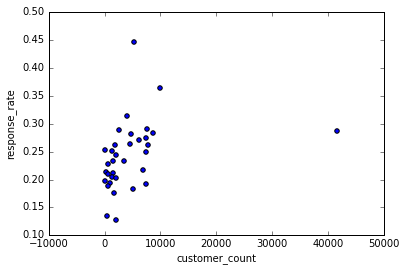

In [124]:
%matplotlib inline
import matplotlib.pyplot as plt
count_vs_rate.plot(kind='scatter', x='customer_count', y='response_rate')

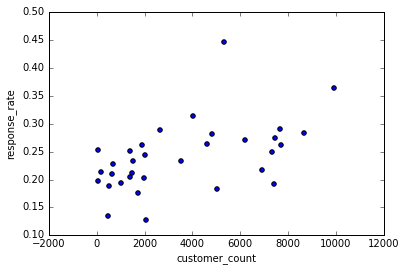

In [125]:
count_vs_rate[count_vs_rate.customer_count < 40000].plot(kind='scatter', x='customer_count', y='response_rate')

There is a weak relationship there, but we probably won't want to employ something as nuanced as this in our first iteration of analysis. Interesting to know though!

We understand a little bit of the offer history data. Let's just check for missing values.

Now we need to repeat the process across our other datasets. Let's start with the offers.

In [126]:
offers.describe(["quantity", "offervalue"]).show()

+-------+------------------+------------------+
|summary|          quantity|        offervalue|
+-------+------------------+------------------+
|  count|                37|                37|
|   mean| 1.027027027027027|1.6486486486486487|
| stddev|0.1643989873053573|0.7347038789810421|
|    min|               1.0|              0.75|
|    max|               2.0|               5.0|
+-------+------------------+------------------+



Looks as though a small number of the offers have a different _quantity_ value.

In [127]:
offers.groupBy("quantity").count().show()

+--------+-----+
|quantity|count|
+--------+-----+
|     1.0|   36|
|     2.0|    1|
+--------+-----+



Interesting. Is this still applicable when we join _offers_ to our _history_ dataset?

In [128]:
offers[offers.quantity == 2].show()

+-------+--------+--------+---------+----------+-----+
|  offer|category|quantity|  company|offervalue|brand|
+-------+--------+--------+---------+----------+-----+
|1221658|    7205|     2.0|103700030|       3.0| 4294|
+-------+--------+--------+---------+----------+-----+



In [129]:
trainHistory[trainHistory.offer=="1221658"].count()

0

No. In which case, it's not going to be significant for our analysis and modelling.  
Do any of the categorical fields have few enough levels to enter into a simple classification model?

In [130]:
offers.groupBy("company").count().orderBy("count", ascending = False).show()

+----------+-----+
|   company|count|
+----------+-----+
| 104460040|    7|
| 103700030|    5|
| 107120272|    5|
| 107717272|    2|
| 105450050|    2|
|1076211171|    2|
|1087744888|    2|
| 105100050|    2|
| 103320030|    1|
| 107127979|    1|
| 104610040|    1|
| 105190050|    1|
| 107106878|    1|
| 106414464|    1|
| 104127141|    1|
| 108500080|    1|
|1089520383|    1|
| 108079383|    1|
+----------+-----+



In [131]:
offers.groupBy("brand").count().orderBy("count", ascending = False).show()

+------+-----+
| brand|count|
+------+-----+
|  5072|    5|
|  4294|    5|
|  7668|    5|
| 64486|    2|
|102504|    2|
|  3718|    2|
| 17286|    2|
| 13791|    2|
|  1322|    2|
|  6732|    1|
| 26456|    1|
| 28840|    1|
|  6926|    1|
| 17311|    1|
| 93904|    1|
| 13474|    1|
| 15889|    1|
| 26189|    1|
|   875|    1|
+------+-----+



In [132]:
offers.groupBy("category").count().orderBy("count", ascending = False).show()

+--------+-----+
|category|count|
+--------+-----+
|    7205|    5|
|    5558|    5|
|     799|    2|
|    4517|    2|
|    4401|    2|
|    5619|    2|
|    1726|    2|
|    6202|    2|
|    2202|    2|
|    9909|    2|
|    1703|    2|
|    3504|    1|
|    3509|    1|
|    9115|    1|
|     706|    1|
|    5824|    1|
|    2119|    1|
|    3203|    1|
|    5616|    1|
|    5122|    1|
+--------+-----+



These might work in a classification tree model which automatically groups, or as a binned aggregate measure of the response rate across each.  
Let's move on to the transactions.

What is the range of dates of our transactions?

In [133]:
transactions.agg(
    F.min("date").alias("date_min")
    ,F.max("date").alias("date_max")).show()

+----------+----------+
|  date_min|  date_max|
+----------+----------+
|2012-03-02|2013-07-28|
+----------+----------+



Right, so up to a year before the offers were presented.  
What are the ranges of _purchasequantity_ and _purchaseamount_?

In [134]:
transactions.describe(["productsize"
                       ,"productmeasure"
                       ,"purchasequantity"
                       , "purchaseamount"]).show()

+-------+------------------+--------------+------------------+-----------------+
|summary|       productsize|productmeasure|  purchasequantity|   purchaseamount|
+-------+------------------+--------------+------------------+-----------------+
|  count|          27764694|      27764694|          27764694|         27764694|
|   mean|28.733898486697075|          null|1.4904842819445443|5.286881874218255|
| stddev|42.335490620192346|          null|3.8869839815667038|9.019249258411122|
|    min|               0.0|            CT|             -27.0|          -885.04|
|    max|            1080.0|            YD|           11845.0|         20728.75|
+-------+------------------+--------------+------------------+-----------------+



OK, we have some returns data in here, too. We may need to account for this in a future iteration of modelling work.   

<a id="prepare"></a>
# 3. Data preparation
The output of this phase is a dataset with which we can build and test models.  
Given that the aim of the task is to make customer-offer level predictions about likelihood to become a repeat purchaser, data that we use from the _offers_ or _transactions_ datasets will need to be joined to the _history_ dataset.  
We have also observed that the _transactions_ dataset contains a large volume of datat, too much to enter into a model without aggregation to the customer, offer level. In aggregating this, our goal is to select an approach which generates features that:

a)  retain as much information about the behaviour of these customers as possible; and  
b)  will be usable in our model (some algorithms can only accept numerical inputs, for example).

As a starter set, we will simply measure how much each customer had spent in the 30, 60, 90 and 180 days prior to being made an offer.  
To do so, we will first need to join the offer history and transactions tables.

In [135]:
offertxns = transactions.join(trainHistory.select(["id" , "chain", "offer", "offerdate", "repeater"]), ["id", "chain"], how = "inner")
offertxns.show(n=5)

+-----+-----+----+--------+----------+-----+----------+-----------+--------------+----------------+--------------+-------+----------+--------+
|   id|chain|dept|category|   company|brand|      date|productsize|productmeasure|purchasequantity|purchaseamount|  offer| offerdate|repeater|
+-----+-----+----+--------+----------+-----+----------+-----------+--------------+----------------+--------------+-------+----------+--------+
|86246|  205|   3|     305| 103320030|  875|2013-03-09|       16.0|            OZ|             1.0|          0.99|1208251|2013-04-24|     1.0|
|86246|  205|   3|     305| 103320030|  875|2013-03-10|       32.0|            OZ|             1.0|          1.69|1208251|2013-04-24|     1.0|
|86246|  205|   3|     305| 103320030|  875|2013-04-04|        8.0|            OZ|             2.0|          1.38|1208251|2013-04-24|     1.0|
|86246|  205|   6|     610| 108079383|12778|2013-04-20|       16.0|            OZ|             1.0|          1.99|1208251|2013-04-24|     1.0|

Calculate "history" interval dates based on _offerdate_.

In [136]:
offertxns = offertxns.withColumn("offerdate_30", F.date_sub(offertxns.offerdate, 30))
offertxns = offertxns.withColumn("offerdate_60", F.date_sub(offertxns.offerdate, 60))
offertxns = offertxns.withColumn("offerdate_90", F.date_sub(offertxns.offerdate, 90))
offertxns = offertxns.withColumn("offerdate_180", F.date_sub(offertxns.offerdate, 180))
offertxns.show(n=5)

+-----+-----+----+--------+----------+-----+----------+-----------+--------------+----------------+--------------+-------+----------+--------+------------+------------+------------+-------------+
|   id|chain|dept|category|   company|brand|      date|productsize|productmeasure|purchasequantity|purchaseamount|  offer| offerdate|repeater|offerdate_30|offerdate_60|offerdate_90|offerdate_180|
+-----+-----+----+--------+----------+-----+----------+-----------+--------------+----------------+--------------+-------+----------+--------+------------+------------+------------+-------------+
|86246|  205|   3|     305| 103320030|  875|2013-03-09|       16.0|            OZ|             1.0|          0.99|1208251|2013-04-24|     1.0|  2013-03-25|  2013-02-23|  2013-01-24|   2012-10-26|
|86246|  205|   3|     305| 103320030|  875|2013-03-10|       32.0|            OZ|             1.0|          1.69|1208251|2013-04-24|     1.0|  2013-03-25|  2013-02-23|  2013-01-24|   2012-10-26|
|86246|  205|   3|  

We can employ a Spark "user defined function" to create corresponding aggregation flags to identify whether the transaction in scope of one of the history periods.

In [137]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

def inDateRange(date, date_lower, date_upper):
    if date >= date_lower and date <= date_upper: return 1
    else: return 0

udfInDateRange = udf(inDateRange, IntegerType())
    
offertxns = offertxns.withColumn("offerdate_30_tf", udfInDateRange(offertxns.date, offertxns.offerdate_30, offertxns.offerdate))
offertxns = offertxns.withColumn("offerdate_60_tf", udfInDateRange(offertxns.date, offertxns.offerdate_60, offertxns.offerdate))
offertxns = offertxns.withColumn("offerdate_90_tf", udfInDateRange(offertxns.date, offertxns.offerdate_90, offertxns.offerdate))
offertxns = offertxns.withColumn("offerdate_180_tf", udfInDateRange(offertxns.date, offertxns.offerdate_180, offertxns.offerdate))
offertxns.show(n=5)

+-----+-----+----+--------+----------+-----+----------+-----------+--------------+----------------+--------------+-------+----------+--------+------------+------------+------------+-------------+---------------+---------------+---------------+----------------+
|   id|chain|dept|category|   company|brand|      date|productsize|productmeasure|purchasequantity|purchaseamount|  offer| offerdate|repeater|offerdate_30|offerdate_60|offerdate_90|offerdate_180|offerdate_30_tf|offerdate_60_tf|offerdate_90_tf|offerdate_180_tf|
+-----+-----+----+--------+----------+-----+----------+-----------+--------------+----------------+--------------+-------+----------+--------+------------+------------+------------+-------------+---------------+---------------+---------------+----------------+
|86246|  205|   3|     305| 103320030|  875|2013-03-09|       16.0|            OZ|             1.0|          0.99|1208251|2013-04-24|     1.0|  2013-03-25|  2013-02-23|  2013-01-24|   2012-10-26|              0|      

At this point we can calculate the quantity and spend per customer per offer.  
As an extension, you could join onto the offers table and create equivalent measures for quantity and spend in the same brand, company and category as the offer presented to the customer.

In [138]:
offertxns = offertxns.withColumn("offerdate_30_qty", offertxns.purchasequantity * offertxns.offerdate_30_tf)
offertxns = offertxns.withColumn("offerdate_60_qty", offertxns.purchasequantity * offertxns.offerdate_60_tf)
offertxns = offertxns.withColumn("offerdate_90_qty", offertxns.purchasequantity * offertxns.offerdate_90_tf)
offertxns = offertxns.withColumn("offerdate_180_qty", offertxns.purchasequantity * offertxns.offerdate_180_tf)

offertxns = offertxns.withColumn("offerdate_30_amt", offertxns.purchaseamount * offertxns.offerdate_30_tf)
offertxns = offertxns.withColumn("offerdate_60_amt", offertxns.purchaseamount * offertxns.offerdate_60_tf)
offertxns = offertxns.withColumn("offerdate_90_amt", offertxns.purchaseamount * offertxns.offerdate_90_tf)
offertxns = offertxns.withColumn("offerdate_180_amt", offertxns.purchaseamount * offertxns.offerdate_180_tf)
offertxns.show(n=5)

+-----+-----+----+--------+----------+-----+----------+-----------+--------------+----------------+--------------+-------+----------+--------+------------+------------+------------+-------------+---------------+---------------+---------------+----------------+----------------+----------------+----------------+-----------------+----------------+----------------+----------------+-----------------+
|   id|chain|dept|category|   company|brand|      date|productsize|productmeasure|purchasequantity|purchaseamount|  offer| offerdate|repeater|offerdate_30|offerdate_60|offerdate_90|offerdate_180|offerdate_30_tf|offerdate_60_tf|offerdate_90_tf|offerdate_180_tf|offerdate_30_qty|offerdate_60_qty|offerdate_90_qty|offerdate_180_qty|offerdate_30_amt|offerdate_60_amt|offerdate_90_amt|offerdate_180_amt|
+-----+-----+----+--------+----------+-----+----------+-----------+--------------+----------------+--------------+-------+----------+--------+------------+------------+------------+-------------+-------

In [139]:
offertxnsSum = offertxns.groupBy(["id", "chain", "offer", "offerdate", "repeater"]).agg(
    F.sum("offerdate_30_qty").alias("qty_30")
    , F.sum("offerdate_60_qty").alias("qty_60")
    , F.sum("offerdate_90_qty").alias("qty_90")
    , F.sum("offerdate_180_qty").alias("qty_180")
    , F.sum("offerdate_30_amt").alias("amt_30")
    , F.sum("offerdate_60_amt").alias("amt_60")
    , F.sum("offerdate_90_amt").alias("amt_90")
    , F.sum("offerdate_180_amt").alias("amt_180"))
offertxnsSum.show(n=5)

+---------+-----+-------+----------+--------+------+------+------+-------+------------------+------------------+------------------+------------------+
|       id|chain|  offer| offerdate|repeater|qty_30|qty_60|qty_90|qty_180|            amt_30|            amt_60|            amt_90|           amt_180|
+---------+-----+-------+----------+--------+------+------+------+-------+------------------+------------------+------------------+------------------+
|499743981|   21|1197502|2013-03-28|     0.0|  10.0|  26.0|  26.0|   29.0|             44.53|             94.15|             94.15|107.13000000000001|
|499969321|   21|1208501|2013-04-29|     1.0|   9.0|  17.0|  30.0|   51.0|47.610000000000014| 72.43000000000002|108.10999999999997|            180.65|
|500066184|   21|1197502|2013-03-26|     0.0|   0.0|   1.0|   4.0|    9.0|               0.0|              3.59|39.059999999999995|              54.2|
|500119603|   21|1208501|2013-04-28|     1.0|   2.0|  11.0|  19.0|   76.0|              5.16| 

What is the average spend in these intervals?  
Spark will allow us to calculate this quite easily. In order to plot this nicely, we will need help from the Python data wrangling library of choice: Pandas. Luckily Spark also offers an easy way to translate between the two types of object using the  _.toPandas()_ function.

In [140]:
import pandas as pd
average_spend = offertxnsSum.groupBy("repeater").agg(
    F.avg("amt_30").alias("30")
    , F.avg("amt_60").alias("60")
    , F.avg("amt_90").alias("90")
    , F.avg("amt_180").alias("180")).toPandas()

average_spend_melt = pd.melt(average_spend, id_vars = "repeater", var_name = "interval_days", value_name = "spend_ave")
average_spend_melt["interval_days"] = pd.to_numeric(average_spend_melt["interval_days"])

average_spend_melt.head()

,repeater,interval_days,spend_ave
0,0,30,28.461137
1,1,30,61.563338
2,0,60,59.186021
3,1,60,125.753266
4,0,90,90.999413


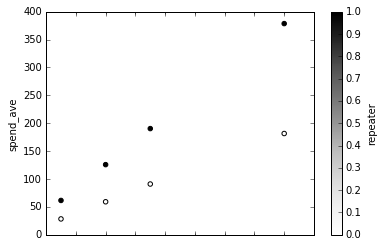

In [141]:
average_spend_melt.plot(kind='scatter', x='interval_days', y='spend_ave', c="repeater")

<a id="model"></a>
# 4. Modelling experiments
We're now ready to have a first pass at building a model.  

## 4.1 Holdout partitioning
For those who have worked in targeted marketing, this approach will be quite familiar. The premise is to train a model based on one part of your dataset and evaluate its performance using the other.  
Spark has a convenience function to do just that: _randomSplit()_. The arguments supplied to this function is an array of weights specifying the proportions by which the dataset should be split.

In [142]:
offertxnsSum = offertxnsSum.withColumnRenamed("repeater","label")
splits = offertxnsSum.randomSplit([0.7,0.3])
trainSet = splits[0]
testSet = splits[1]

trainSet.show(n=5)

+----------+-----+-------+----------+-----+------+------+------+-------+------------------+------------------+-----------------+------------------+
|        id|chain|  offer| offerdate|label|qty_30|qty_60|qty_90|qty_180|            amt_30|            amt_60|           amt_90|           amt_180|
+----------+-----+-------+----------+-----+------+------+------+-------+------------------+------------------+-----------------+------------------+
|1009233077|   46|1199258|2013-03-15|  1.0|   1.0|   5.0|  14.0|   27.0|              3.79|             11.48|            39.24|             81.18|
|1031324422|   46|1199256|2013-03-14|  0.0|  18.0|  25.0|  35.0|   91.0|30.419999999999998|47.510000000000005|75.32000000000001|283.56000000000006|
| 104356531|   15|1204822|2013-04-19|  0.0|   4.0|  10.0|  15.0|   35.0| 7.359999999999999| 35.93000000000001|            45.32|            131.14|
| 105097382|    4|1208251|2013-04-26|  0.0|  11.0|  21.0|  31.0|   49.0|             24.99| 62.99000000000001|87

In [143]:
trainSet.count()

112356

Spark has an idio

In [144]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["qty_30", "qty_60", "qty_90", "qty_180",
              "amt_30", "amt_60", "amt_90", "amt_180"],
    outputCol="features")

trainSetAssembled = assembler.transform(trainSet)
trainSetAssembled.show(n=5, truncate = False)

+----------+-----+-------+----------+-----+------+------+------+-------+------------------+------------------+-----------------+------------------+------------------------------------------------------------------------------------------------+
|id        |chain|offer  |offerdate |label|qty_30|qty_60|qty_90|qty_180|amt_30            |amt_60            |amt_90           |amt_180           |features                                                                                        |
+----------+-----+-------+----------+-----+------+------+------+-------+------------------+------------------+-----------------+------------------+------------------------------------------------------------------------------------------------+
|1009233077|46   |1199258|2013-03-15|1.0  |1.0   |5.0   |14.0  |27.0   |3.79              |11.48             |39.24            |81.18             |[1.0,5.0,14.0,27.0,3.79,11.48,39.24,81.18]                                                      |
|1031324422|46   |11

In [145]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression()
model_lr = lr.fit(trainSetAssembled)

In [146]:
model_lr.coefficients

DenseVector([0.0022, 0.0009, 0.0007, 0.0004, 0.0007, 0.0003, 0.0002, 0.0001])

In [147]:
roc_lr = model_lr.summary.roc
roc_lr = roc_lr.toPandas()
roc_lr.head()

,FPR,TPR
0,0.000000,0.000000
1,0.002494,0.006444
2,0.006236,0.013248
3,0.010295,0.019921
4,0.014453,0.026561


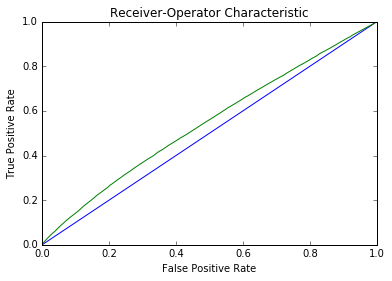

In [148]:
fig = plt.figure()
ax = plt.axes()
ax.set(title = "Receiver-Operator Characteristic",
       xlabel = "False Positive Rate",
      ylabel = "True Positive Rate")

x = [0,1]
y = [0,1]
ax.plot(x, y)
ax.plot(roc_lr.FPR, roc_lr.TPR)
plt.show()

In [149]:
model_lr.summary.areaUnderROC

0.5451202691798842

Not bad, the competition benchmark for this dataset is 0.59.  
Before we start extending this, we should check if our model generalises well by scoring the test set.  
We'll industrialise our model using the pipeline functionality of Spark ML, then use it to transform the test set data.

In [150]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[assembler, lr])
model = pipeline.fit(trainSet)

In [ ]:
prediction = model.transform(testSet)

In [ ]:
# Select example rows to display.
prediction.select("label","prediction", "probability", "features").show(5)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
accuracy = evaluator.evaluate(prediction)
print "Area under the ROC curve = %g " % accuracy

In [ ]:
from sklearn.metrics import roc_curve

prediction_collect = prediction.select("label", "probability").toPandas()
roc_inputs = [(float(i[1][0]), float(i[1][1][1])) for i in prediction_collect.iterrows()]
roc_inputs = pd.DataFrame(roc_inputs, columns = ["label","prob"])
fpr, tpr, _ = roc_curve(y_true = roc_inputs.label, 
                        y_score = roc_inputs.prob)

roc_lr_test = pd.DataFrame(
   {"FPR" : fpr
    ,"TPR" : tpr})

In [ ]:
fig = plt.figure()
ax = plt.axes()
ax.set(title = "Receiver-Operator Characteristic",
       xlabel = "False Positive Rate",
      ylabel = "True Positive Rate")

x = [0,1]
y = [0,1]
ax.plot(x, y)
ax.plot(roc_lr.FPR, roc_lr.TPR)
ax.plot(roc_lr_test.FPR, roc_lr_test.TPR, linestyle="dashed")
plt.show()

<a id="deploy"></a>
# 5. Deploy and score

With the advent of __Watson Machine Learning__, we can quite easily deploy our model to a cloud scoring service.  

## 5.1 Persist Spark model within the ML repository

The first step here is to import the relevant client libraries.

In [ ]:
from repository.mlrepositoryclient import MLRepositoryClient
from repository.mlrepositoryartifact import MLRepositoryArtifact

**Tip**: service_path, user and password can be found on **Service Credentials** tab of service instance created in Bluemix.

For example, the following code:  
```
wml_service_path = "https://ibm-watson-ml.mybluemix.net"  
wml_username = "ebecda6c-a18b-4c6f-82e4-4c7fc26361f4"  
wml_password = "4705d497-fcc0-4e1c-9f55-934b13b13fb2"  
```
Will create the necessary credentials to connect to the Watson ML service. Just substitute in your own in the place of these example values.

In [ ]:
# The code was removed by DSX for sharing.

In [ ]:
ml_repository_client = MLRepositoryClient(wml_service_path)
ml_repository_client.authorize(wml_username, wml_password)

Create model artifact (abstraction layer).

In [ ]:
model_artifact = MLRepositoryArtifact(model, training_data=trainSet, name="Repeat Buyer Prediction Model")

**Tip**: The MLRepositoryArtifact method expects a trained model object, training data, and a model name. (It is this model name that is displayed by the Watson Machine Learning service).  

We can now save our model to the repository.

In [ ]:
saved_model = ml_repository_client.models.save(model_artifact)

Get saved model metadata from Watson Machine Learning.  
**Tip**: Use *meta.available_props()* to get the list of available props.

In [ ]:
saved_model.meta.available_props()

In [ ]:
print "modelType: " + saved_model.meta.prop("modelType")
print "trainingDataSchema: " + str(saved_model.meta.prop("trainingDataSchema"))
print "creationTime: " + str(saved_model.meta.prop("creationTime"))
print "modelVersionHref: " + saved_model.meta.prop("modelVersionHref")
print "label: " + saved_model.meta.prop("label")

**Tip**: **modelVersionHref** is our model unique indentifier in the Watson Machine Learning repository.

## 5.2 Create an online scoring endpoint
In this section you will learn how to create online scoring and to score a new data record by using the Watson Machine Learning REST API.  
For more information about REST APIs, see the [Swagger Documentation](http://watson-ml-api.mybluemix.net/).  
To work with the Watson Machine Leraning REST API you must generate an access token. To do that you can use the following sample code:

In [ ]:
import urllib3, requests, json

headers = urllib3.util.make_headers(basic_auth='{}:{}'.format(wml_username, wml_password))
url = '{}/v2/identity/token'.format(wml_service_path)
response = requests.get(url, headers=headers)
mltoken = json.loads(response.text).get('token')
print mltoken

You can now create an online scoring endpoint. Execute the following sample code that uses the **modelVersionHref** value to create the scoring endpoint to the Bluemix repository.

In [ ]:
endpoint_online = wml_service_path + "/v2/online/deployments/"
header_online = {'Content-Type': 'application/json', 'Authorization': mltoken}
payload_online = {"artifactVersionHref": saved_model.meta.prop("modelVersionHref"), "name": "Repeat Shopper Prediction"}

print endpoint_online
print header_online
print payload_online

response_online = requests.post(endpoint_online, json=payload_online, headers=header_online)

print response_online
print response_online.text

scoring_href = json.loads(response_online.text).get('entity').get('scoringHref')
print scoring_href

Let's see what happens when we send a PUT request to our new endpoint containing a new scoring record. The model should hopefully return some predictions.

In [ ]:
payload_scoring = {
    "record":[
        "42", #id                     
        "8620", #chain
        "400", #offer
        "2017-6-5", #offerdate
        5, #qty_30
        10, #qty_60
        15, #qty_90
        20, #qty_180
        50, #amt_30
        100, #amt_60
        150, #amt_90
        200, #amt_180
    ]}

response_scoring = requests.put(scoring_href, json=payload_scoring, headers=header_online)

print response_scoring.text

<a id="tuning"></a>
# 6. Taking it further: analysis iterations and model tuning

Can you get closer to the benchmark? Think about how you might improve the accuracy of our predictions, perhaps by:
  - engineering more detailed features;
  - experimenting with different modelling algorithms; or
  - employing alternative approaches to model validation.